In [13]:
from graphdatascience import GraphDataScience
import pandas as pd
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
URI = "neo4j+s://53af82ec.databases.neo4j.io"
PASS = "z_vhx_qdnujnJNitjVLdZOI6l_KgQ8TuWGe7yZqkXf4"

In [14]:
gds = GraphDataScience(URI, auth=("neo4j", PASS))


# Count of Metaversal Badge Holders -

Earlier, I applied the `Metaversal` label to wallets that hold the Metaversal badge (for ease of analysis).

In [58]:
metaversalist_badge_holders  = """
match
    (w:Wallet:Metaversal)
return 
    count(distinct(w)) as count_wallets

"""
gds.run_cypher(metaversalist_badge_holders)

count_wallets
0            607

# Identify Incentive Farming wallets

We group spammers, airdrop farmers, and other wallets engaged that engage in behaviors designed to extract value from communities (as opposed to adding value to communities) under the umbrella of `Incentive Farming`.

We have a few ways of identifying `Incentive Farmer` wallets.

I'll start with the most simple -- rules-based matching. Our rules cover behavior like using bots to publish articles on Mirror, creating a "legend" for a wallet by voting in fake DAOs, or deploying spam NFT contracts. 


In [60]:
rules_based_spammers = """
match
    (w:Wallet:Metaversal)-[r:_HAS_CONTEXT]->(context:_IncentiveFarming)
return 
    count(distinct(w)) as count_wallets
"""
gds.run_cypher(rules_based_spammers)

count_wallets
0             59

### Rules-based results

So, 59 out of the 607 Metaversalist badge holders are (with high confidence) incentive farmers. 

This comes out to 9.7% of wallets.


### Likely incentive farmers
We can also infer whether a wallet is (likely) an incentive farmer through network analytics. 

All of the nodes in the graph have an "embedding." The embedding compresses context about the nodes relationships and properties into a vector, or array of numbers. 

Here are the embeddings for my wallet.

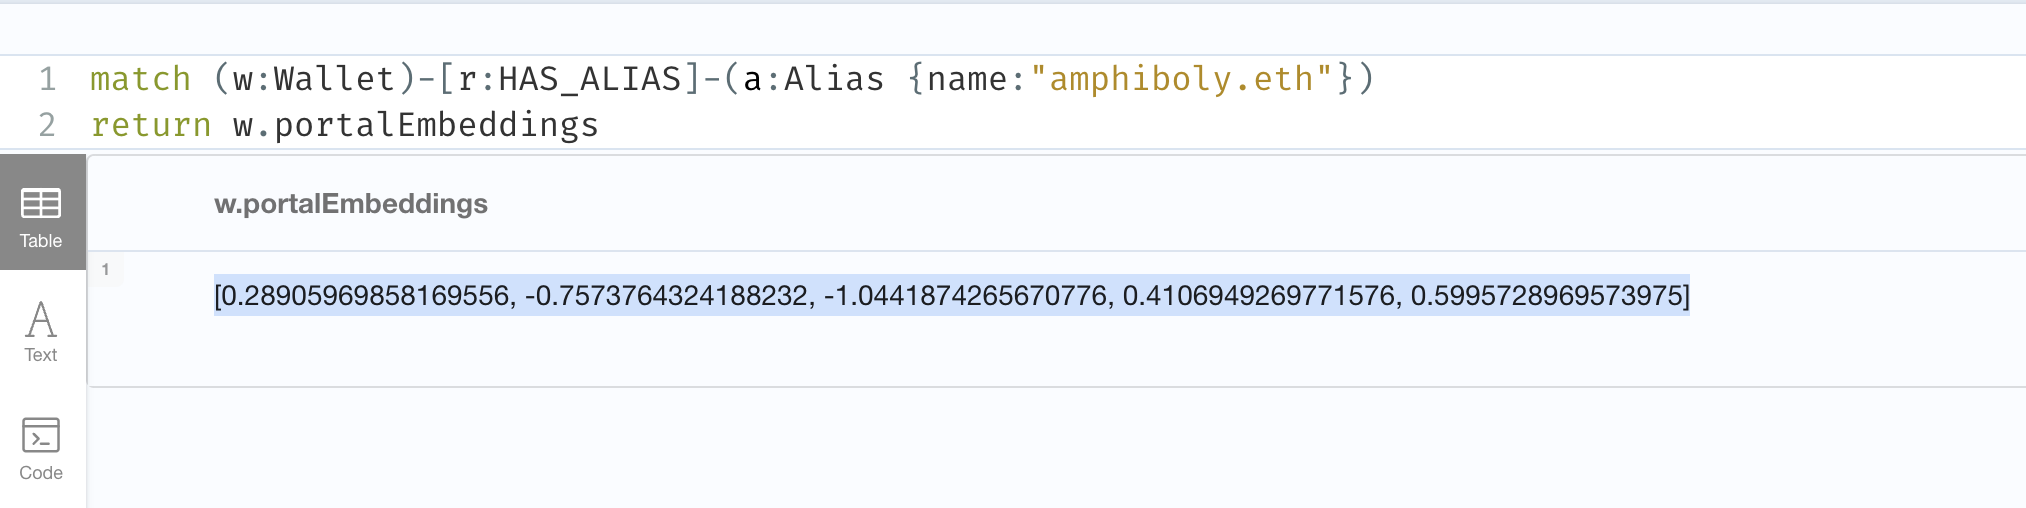

Embeddings are great because they allow us to measure the similarity of any node (or set of nodes) in the graph to another node (or set of nodes).

The query bellow takes our `Suspect` wallets, calculates the average, and the compares the average against all of the other Metaversal badgeholders. Badgeholders who are at least 95% similar to the badgeholders are labeled `Highly Suspect`.

In [65]:
suspect_highly_similar = """
match
    (suspect:Wallet:Metaversal)-[r:_HAS_CONTEXT]->(context:_IncentiveFarming)
with 
    suspect, collect(distinct(suspect.portalEmbeddings)) as embeddings 
with [
  average in reduce(
    sum_values=[], embedding IN embeddings | 
    case when size(sum_values) = 0 then embedding
    else [
      i in range(0, size(sum_values)-1) |
      sum_values[i] + embedding[i]
    ] end) |
    average / tofloat(size(embeddings))
] as avg, suspect
match
    (other:Wallet:Metaversal)
where not 
    id(other) = id(suspect)
and 
    other.portalEmbeddings is not null 
with 
    other, gds.similarity.cosine(avg, other.portalEmbeddings) as similarity
where
    similarity > .95
set
    other:HighlySuspect
return
    count(distinct(other)) as `highly similar suspect`"""

gds.run_cypher(suspect_highly_similar)


highly similar suspect
0                     232

### Highly suspect

An additional 232 Metaversal badge holders (~38%) are likely incentive farmers. 

So, conservatively 291 Metaversal badge holders (~47%) are either incentive farmers or very likely incentive farmers.

## High value wallets

On to high value community members. First, how many wallets remain, after we filter out the suspect wallets?

In [67]:
potentially_high_value = """
match
    (w:Wallet:Metaversal)
where not
    ((w:HighlySuspect))
set
    w:PotentiallyHighValue
return 
    count(distinct(w)) as count
"""
gds.run_cypher(potentially_high_value)

count
0    375

### Potentially high value

375, or about 61%. 

Great. So out of those, how many have meaningfully participated in Web3?

We focus on *participation*, i.e. voting, writing on Mirror, donating to grants, contributing code to projects, because we believe that participation is more important than *speculation* for sustained community growth.  

In [68]:
high_value = """
match
    (w:Wallet:Metaversal)
where not
    ((w:Suspect) or (w:HighlySuspect))
with
    w
match
    (w)-[:_HAS_CONTEXT]->(c:_Context) 
set 
    w:HighValue
return
    count(distinct(w)) as `high value`
"""
gds.run_cypher(high_value)

high value
0          93

### High value results

So 93 Metaversalist pass holders (~15%) are high value. 

Why? You can look at the breakdown of their `Chainverse Labels` below.

Chainverse Labels categorize the type, substance, and signifigance of a wallets' participation in the broader Web3 ecosystem.

These are very rough "VO" labels, designed to start the conversation and collect user feedback. We'll be overhauling them over the next couple of months, based on user requirements.

In [70]:
high_value_breakdown = """
match
    (w:Wallet:Metaversal:HighValue)-[r:_HAS_CONTEXT]->(context:_Context)
return distinct
    context._displayName as label, 
    context._main as category,
    count(distinct(w)) as wallets
order by
    wallets desc
"""
gds.run_cypher(high_value_breakdown)

label                          category  wallets
0           GenderFocusedProposal  Diversity, Equity, and Inclusion       49
1                    EngagedVoter              Protocol Politicians       46
2                    MirrorAuthor               Creators + Curators        8
3                 UrmFocusedGrant  Diversity, Equity, and Inclusion        8
4               GitcoinGrantDonor             Ecosystem Development        7
5             Suspicious Snapshot                 Incentive Farming        6
6              UrmFocusedProposal  Diversity, Equity, and Inclusion        6
7                        DaoAdmin                     EarlyAdopters        5
8                   EarlySnapshot                     EarlyAdopters        5
9                        DaoAdmin              Protocol Politicians        5
10                BlueChipGeneric               Creators + Curators        5
11  Incentive Farming - Co-signer                 Incentive Farming        3
12                      GrantsDao             Ecosystem Development        3
13           IncubatorParticipant             Ecosystem Development        2
14              GitcoinGrantAdmin             Ecosystem Development        1

## Dig deeper

Last, I'll export the badge holders to a CSV, so you can review them, and go deeper on wallets of interest.

For instance, you can put any wallet address or ENS name into Chainverse (portal.chainversedata.com) to quickly review their most important interests and affiliations.

I also flag holders that are OmegaRunner NFT holders.

The table is sorted by Chainverse Reputation -- i.e how many Chainverse Labels they have.

Here is the network of the top result -- caseyschooner.eth. 

Their Web3 engagement spans DeFi (i.e. Aave, Olympus) as well as the creator economy and Web3 media. 
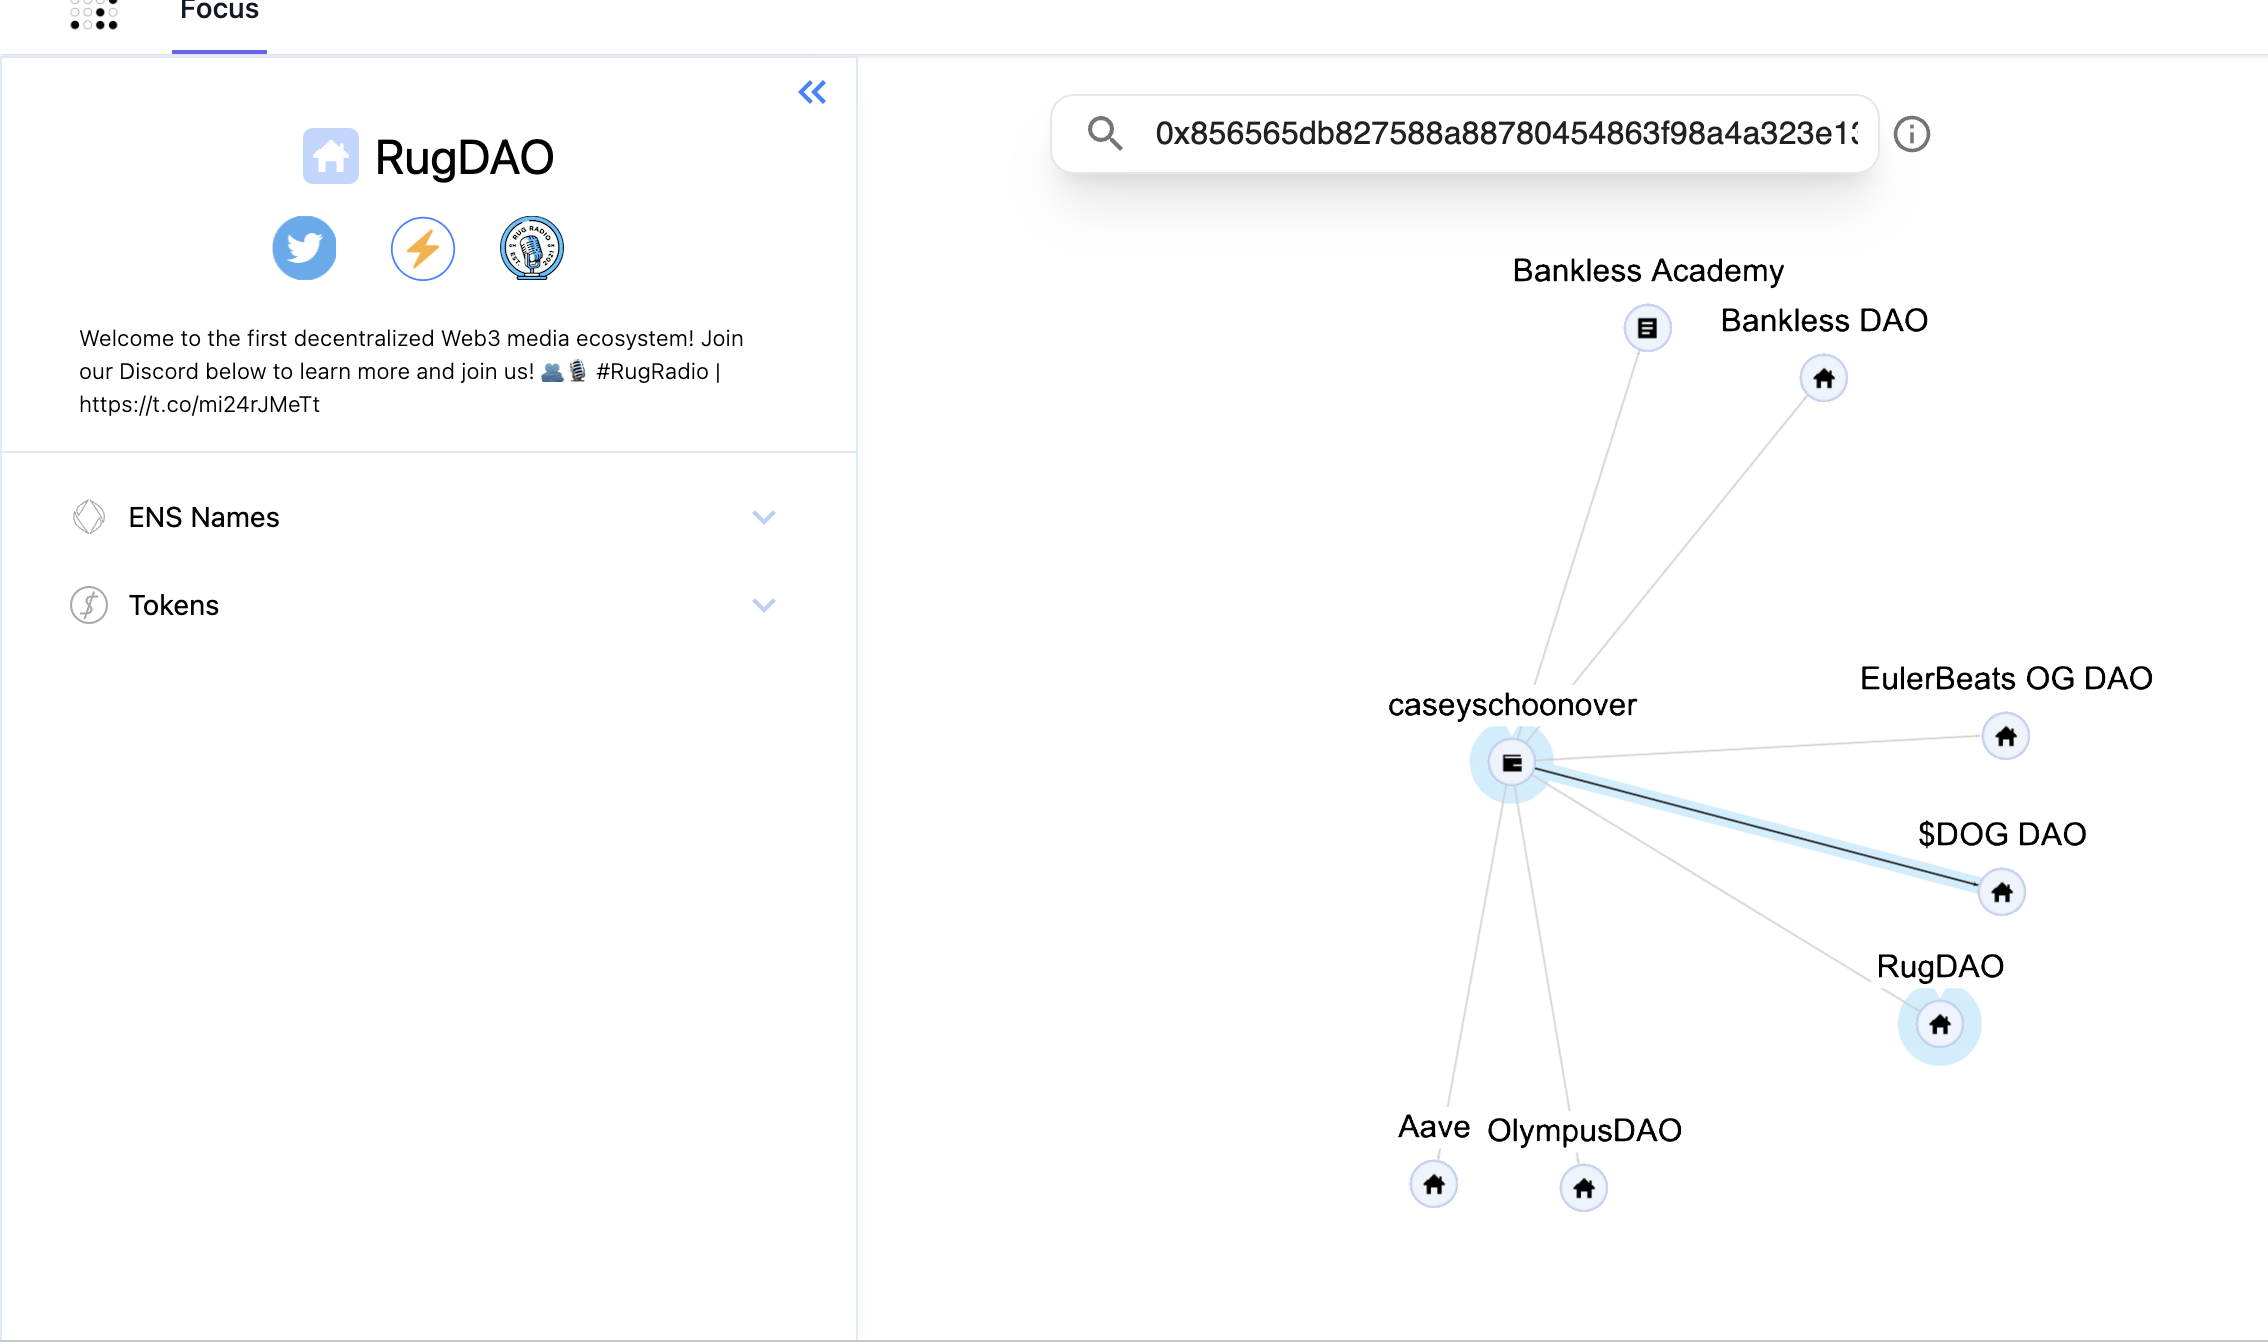


Our UI will go beyond distinguishing high-value users from low value users, to providing customers with actionable recommendations on which audiences to pursue and how to pursue them.



In [72]:
subscribers_for_review = """
match
    (w:Wallet:Metaversal:HighValue)-[r:_HAS_CONTEXT]->(context:_Context)
optional match
    (w)-[:HAS_ALIAS]-(:Alias)-[:HAS_ALIAS]-(twitter:Twitter) 
optional match
    (w)-[:HAS_ALIAS]-(alias:Alias)
return distinct
    w.address as address, 
    collect(distinct(alias.name)) as ens_names, 
    collect(distinct(twitter.handle)) as twitter_handles,
    collect(distinct(context._displayName)) as chainverseLabels,
    count(distinct(context)) as chainverseReputation,
    w:OmegaRunner as OmegaRunnerHolder
order by
    chainverseReputation desc
"""

gds.run_cypher(subscribers_for_review)
subscribers_csv = gds.run_cypher(subscribers_for_review)
subscribers_csv.to_csv("high_value_subscribers.csv")